# 1. Text preprocessing

1.1. Getting data

In [21]:
with open('makiavelli_traktat_gosudar.txt', 'r') as f:
  X = f.read()

X

'\ufeff\nНиколо Макиавелли\n\nГосударь\n\nНиколо Макиавелли — его светлости Лоренцо деи Медичи\n\n\nОбыкновенно, желая снискать милость правителя, люди посылают ему в дар то, что имеют самого дорогого, или чем надеются доставить ему наибольшее удовольствие, а именно: коней, оружие, парчу, драгоценные камни и прочие украшения, достойные величия государей. Я же, вознамерившись засвидетельствовать мою преданность Вашей светлости, не нашел среди того, чем владею, ничего более дорогого и более ценного, нежели познания мои в том, что касается деяний великих людей, приобретенные мною многолетним опытом в делах настоящих и непрестанным изучением дел минувших. Положив много времени и усердия на обдумывание того, что я успел узнать, я заключил свои размышления в небольшом труде, который посылаю в дар Вашей светлости. И хотя я полагаю, что сочинение это недостойно предстать перед вами, однако же верю, что по своей снисходительности вы удостоите принять его, зная, что не в моих силах преподнести в

1.2 Normalizing text

In [22]:
import nltk
import re

X = re.sub(r'\t+|\n+|\xa0—|\ufeff', ' ', X)
nltk.download('punkt')
X = nltk.tokenize.sent_tokenize(X)
X = [sent for sent in X if not re.match('ГЛАВА [XVI]{1,4}', sent)]
print(len(X))
X

841


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['  Николо Макиавелли Государь Николо Макиавелли — его светлости Лоренцо деи Медичи Обыкновенно, желая снискать милость правителя, люди посылают ему в дар то, что имеют самого дорогого, или чем надеются доставить ему наибольшее удовольствие, а именно: коней, оружие, парчу, драгоценные камни и прочие украшения, достойные величия государей.',
 'Я же, вознамерившись засвидетельствовать мою преданность Вашей светлости, не нашел среди того, чем владею, ничего более дорогого и более ценного, нежели познания мои в том, что касается деяний великих людей, приобретенные мною многолетним опытом в делах настоящих и непрестанным изучением дел минувших.',
 'Положив много времени и усердия на обдумывание того, что я успел узнать, я заключил свои размышления в небольшом труде, который посылаю в дар Вашей светлости.',
 'И хотя я полагаю, что сочинение это недостойно предстать перед вами, однако же верю, что по своей снисходительности вы удостоите принять его, зная, что не в моих силах преподнести вам д

1.3 Vectorization

In [3]:
nltk.download('stopwords')
from nltk.corpus import stopwords
!python -m spacy download ru_core_news_md
import spacy
nlp = spacy.load('ru_core_news_md')
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def tokenizer(sent):
  return [token.lemma_ for token in nlp(sent) if token.is_alpha]

stop_words = stopwords.words('russian')
vectorizer = CountVectorizer(binary=True,
                             stop_words = stop_words,
                             tokenizer = tokenizer)
data = vectorizer.fit_transform(X)
data = pd.DataFrame(data.todense(),
                    columns=vectorizer.get_feature_names_out())
data.info()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2022-11-03 13:38:46.753384: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41.9 MB 89 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_md')


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['весь', 'мочь', 'ничто', 'свой', 'хороший', 'это'] not in stop_words.
  % sorted(inconsistent)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841 entries, 0 to 840
Columns: 3722 entries, ii to ясный
dtypes: int64(3722)
memory usage: 23.9 MB


# 2. Clustering tokens

2.1 Agglomeration model fitting

In [4]:
from sklearn.cluster import FeatureAgglomeration

model = FeatureAgglomeration(n_clusters = None, distance_threshold = 0.1)
model.fit(data)
max_dist = max(model.distances_)

# максимальные расстояния между точками
max_dist

23.77616076771901

2.2 Hyperparameter search

In [5]:
import numpy as np

dims = []
step = max_dist/50
for i in np.arange(step, max_dist, step):
  model = FeatureAgglomeration(n_clusters = None, distance_threshold = i)
  clusters = model.fit_transform(data)
  dims.append({'param': round(i, 3),
               'dim': clusters.shape[1]})
  
dims[:5]

[{'param': 0.476, 'dim': 2423},
 {'param': 0.951, 'dim': 2423},
 {'param': 1.427, 'dim': 1749},
 {'param': 1.902, 'dim': 1460},
 {'param': 2.378, 'dim': 1176}]

2.3 Calculating differences

In [6]:
last = len(dims) - 1
dims[last]['diff'] = 0
for i, dim in enumerate(dims):
  if i == last:
    break
  dim['diff'] = dim['dim'] - dims[i+1]['dim']
dims[:5]

[{'param': 0.476, 'dim': 2423, 'diff': 0},
 {'param': 0.951, 'dim': 2423, 'diff': 674},
 {'param': 1.427, 'dim': 1749, 'diff': 289},
 {'param': 1.902, 'dim': 1460, 'diff': 284},
 {'param': 2.378, 'dim': 1176, 'diff': 242}]

2.4 Visualizing

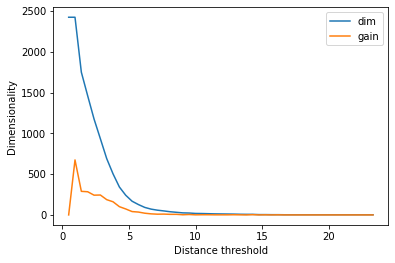

In [7]:
from matplotlib import pyplot as plt

param_list = [x['param'] for x in dims]
dim_list = [x['dim'] for x in dims]
diff_list = [x['diff'] for x in dims]

fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylabel('Dimensionality')
ax.set_xlabel('Distance threshold')
plt.plot(param_list, dim_list, label='dim')
plt.plot(param_list, diff_list, label='gain')
ax.legend()
plt.show()

2.5 Getting optimal cut

In [8]:
dims_sorted = sorted(dims, key=lambda x: x['diff'], reverse=True)
threshold = dims_sorted[0]['param']

model = FeatureAgglomeration(n_clusters = None,
                             distance_threshold = threshold,
                             pooling_func = np.min)
data_clustered = model.fit_transform(data)
data_clustered = pd.DataFrame(data_clustered)
labels = model.labels_

data_clustered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841 entries, 0 to 840
Columns: 2423 entries, 0 to 2422
dtypes: int64(2423)
memory usage: 15.5 MB


# 3. Relation extraction

3.1 Getting itemsets

In [9]:
from mlxtend.frequent_patterns import apriori

min_support = 2/len(data)
itemsets = apriori(data_clustered,
                   min_support = min_support,
                   max_len = 2)
itemsets

,support,itemsets
0,0.010702,(0)
1,0.002378,(1)
2,0.002378,(2)
3,0.002378,(5)
4,0.002378,(6)
...,...,...
11041,0.002378,"(2344, 2311)"
11042,0.003567,"(2354, 2311)"
11043,0.003567,"(2369, 2319)"
11044,0.002378,"(2331, 2367)"


3.2 Searching

In [10]:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(itemsets, min_threshold = min_support)
rules['antecedents'] = rules['antecedents'].apply(lambda x: list(x)[0])
rules['consequents'] = rules['consequents'].apply(lambda x: list(x)[0])

rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,0,370,0.010702,0.129608,0.002378,0.222222,1.714577,0.000991,1.119076
1,370,0,0.129608,0.010702,0.002378,0.018349,1.714577,0.000991,1.007790
2,0,469,0.010702,0.117717,0.002378,0.222222,1.887767,0.001118,1.134364
3,469,0,0.117717,0.010702,0.002378,0.020202,1.887767,0.001118,1.009696
4,0,495,0.010702,0.043995,0.002378,0.222222,5.051051,0.001907,1.229149
...,...,...,...,...,...,...,...,...,...
18661,2319,2369,0.021403,0.043995,0.003567,0.166667,3.788288,0.002626,1.147206
18662,2331,2367,0.002378,0.005945,0.002378,1.000000,168.200000,0.002364,inf
18663,2367,2331,0.005945,0.002378,0.002378,0.400000,168.200000,0.002364,1.662703
18664,2369,2383,0.043995,0.009512,0.002378,0.054054,5.682432,0.001960,1.047087


3.3 Searching for inclusions

In [11]:
incls = rules[rules['confidence'] == 1]
incls = incls[['antecedents', 'consequents']]
# если в предложении есть токен-antecedent, то есть и токен-consequent 100%

incls

,antecedents,consequents
40,1,1627
42,2,1046
45,5,1944
47,6,1168
49,6,1203
...,...,...
18625,2268,2280
18626,2270,2303
18638,2315,2303
18646,2340,2303


# 4. Knowledge Graph

4.1 Creating ontology

In [12]:
!pip install Cython
!pip install owlready2
from owlready2 import *
import types

onto = get_ontology('http://onto.owl')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


4.2 Creating individuals for sentences

In [13]:
with onto:
  onto_sent = types.new_class('Sentence', (Thing,))
  types.new_class('hasText', (DataProperty, FunctionalProperty))
  for i, sent in enumerate(X):
    sent_inst = onto_sent(f'sentence_{i}')
    sent_inst.hasText = sent
    
onto.save('onto.owl')

4.3 Creating classes for tokens

In [14]:
with onto:
  onto_token = types.new_class('Token', (Thing,))
  for i, token in enumerate(data.columns):
    token_inst = onto_token(f'token_{i}')
    token_inst.label = token

onto.save('onto.owl')

4.4 Linking sentences with tokens

In [15]:
with onto:
  hasToken = types.new_class('hasToken', (ObjectProperty,))
  for i, row in data.iterrows():
    sent_inst = onto[f'sentence_{i}']
    for j, token in enumerate(data.columns):
      if row[token] == 1:
        token_inst = onto[f'token_{j}']
        sent_inst.hasToken.append(token_inst)

onto.save('onto.owl')

4.5 Creating clusters

In [16]:
with onto:
  onto_clust = types.new_class('Cluster', (Thing,))
  for label in set(labels):
    clust_cl = types.new_class(f'Cluster_{label}', (onto_clust,))

onto.save('onto.owl')

4.6 Linking clusters with tokens

In [17]:
with onto:
  for i, label in enumerate(labels):
    clust_cl = onto[f'Cluster_{label}']
    token_inst = onto[f'token_{i}']
    clust_cl.equivalent_to.append(hasToken.value(token_inst))
onto.save('onto.owl')

4.7 Setting inclusions

In [18]:
with onto:
  for index, row in incls.iterrows():
    ant = row['antecedents']
    con = row['consequents']
    ant_cl = onto[f'Cluster_{ant}']
    con_cl = onto[f'Cluster_{con}']
    reverse = incls[(incls['antecedents'] == con) & (incls['consequents'] == ant)]
    if reverse.empty:
      # SubclassOf
      ant_cl.is_a.append(con_cl)
    else:
      ant_cl.equivalent_to.append(con_cl)
      
onto.save('onto.owl')

In [19]:
# onto = get_ontology("onto.owl").load()

4.8 Running reasoner

In [20]:
with onto:
  sync_reasoner_pellet()

onto.save('onto_reasoned.owl', format='ntriples')

* Owlready2 * Running Pellet...
    java -Xmx2000M -cp /usr/local/lib/python3.7/dist-packages/owlready2/pellet/httpclient-4.2.3.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/slf4j-log4j12-1.6.4.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/aterm-java-1.6.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/commons-codec-1.6.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/xercesImpl-2.10.0.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/xml-apis-1.4.01.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/jena-iri-0.9.5.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/jgrapht-jdk1.5.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/jena-core-2.10.0.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/slf4j-api-1.6.4.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/owlapi-distribution-3.4.3-bin.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/jcl-over-slf4j-1.6.4.jar:/usr/lo